The theory for this notebook is developed in `ZonotopesNonlinearReach`.

In [1]:
# load packages
using Plots
using LazySets, MathematicalSystems, Reachability
using LazySets.Approximations
using Reachability: center
using Reachability.ReachSets: Œ¶‚ÇÅ
using IntervalArithmetic, ValidatedNumerics
using LazySets: Interval, translate
using TaylorSeries
using TaylorSeries: gradient, jacobian, hessian, derivative
const ‚àÇ = derivative

‚îå Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
‚îî @ Base loading.jl:1184


derivative (generic function with 10 methods)

After loading the packages, you should precompile the functions under the section *auxiliary¬†functions* below.

In [67]:
function vanderpol_ASB08()
    # number of Taylor terms considered in the linearization
    taylor_terms = 4

    # define the working variables and fix the max order in the Taylor series expansion
    x = set_variables("x", numvars=2, order=taylor_terms)

    # define the ODE
    f = Vector{TaylorN{Float64}}(undef, 2)
    f[1] = x[2]
    f[2] = x[2] * (1-x[1]^2) - x[1]

    # define the initial-value problem
    
    ùëã‚ÇÄ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
    
    #ùëã‚ÇÄ = split(ùëã‚ÇÄ, [10, 10])[1] # temp
    
    ùëÜ = BlackBoxContinuousSystem(f, 2)
    ùëÉ = InitialValueProblem(ùëÜ, ùëã‚ÇÄ)
    ùëÇ = Options(:Œ¥ => 0.06, :Œ¥cont => 0.05/10, :max_order=>2, :Œ∏=>fill(0.05, 2), :taylor_terms=>taylor_terms,
                :T => 7.0, :plot_vars=>[1, 2],
                :opC => "BFFPSV18", :split_blocks=>[2, 2], :max_chunks=>50)
    return ùëÉ, ùëÇ
end

vanderpol_ASB08 (generic function with 1 method)

In [68]:
@time begin ùëÉ, ùëÇ = vanderpol_ASB08() end

  0.176308 seconds (263.60 k allocations: 14.155 MiB, 12.49% gc time)


(InitialValueProblem{BlackBoxContinuousSystem{Array{TaylorN{Float64},1}},Hyperrectangle{Float64}}(BlackBoxContinuousSystem{Array{TaylorN{Float64},1}}(TaylorN{Float64}[ 1.0 x‚ÇÇ + ùí™(‚Äñx‚Äñ‚Åµ),  - 1.0 x‚ÇÅ + 1.0 x‚ÇÇ - 1.0 x‚ÇÅ¬≤ x‚ÇÇ + ùí™(‚Äñx‚Äñ‚Åµ)], 2), Hyperrectangle{Float64}([1.4, 2.4], [0.15, 0.05])), Options(Dict{Symbol,Any}(:T=>7.0,:Œ¥cont=>0.005,:max_order=>2,:opC=>"BFFPSV18",:split_blocks=>[2, 2],:max_chunks=>50,:taylor_terms=>4,:Œ¥=>0.06,:Œ∏=>[0.05, 0.05],:plot_vars=>[1, 2]‚Ä¶)))

### Algorithm

In [69]:
function post(ùëÉ::InitialValueProblem{<:BBCS}, ùëÇ::Options)

    # get nonlinear ODE
    f = ùëÉ.s.f
    
    # unrwap commonly used options
    Œ¥ = ùëÇ[:Œ¥]
    Œ¥cont = ùëÇ[:Œ¥cont]
    Œ∏ = ùëÇ[:Œ∏]
    T = ùëÇ[:T]
    opC = ùëÇ[:opC]
    split_blocks = ùëÇ[:split_blocks]
    max_chunks = ùëÇ[:max_chunks]
    
    # general options for the continuous post
    ùëÇcont = Options(:T=>Œ¥)

    # algorithm-specific options for the continuous post
    ùëÇ_GLGM06 = Options(:Œ¥=>ùëÇ[:Œ¥cont], :max_order=>ùëÇ[:max_order])
    ùëÇ_BFFPSV18 = Options(:Œ¥=>ùëÇ[:Œ¥cont])
    
    # final result is stored in Rsets
    if opC == "GLGM06"
        Rsets = Vector{ReachSet{Zonotope{Float64}, Float64}}()
    elseif opC == "BFFPSV18" 
        Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
    end

    #times = Vector{Float64}()
    t0 = 0.0 # initial time for each chunk

    # count number of continuous post chunks added to Rsets
    nchunks = 0

    ùëÉ_queue = Vector{typeof(ùëÉ)}()
    push!(ùëÉ_queue, ùëÉ)

    while t0 < T
        while !isempty(ùëÉ_queue)
            ùëÉ_curr = pop!(ùëÉ_queue)

            # obtain linearized system
            xÃÉ, ùëÉlin = linearize(ùëÉ_curr, Œ¥)

            # compute flowpipe of the linearized system
            if opC == "GLGM06"
                Rlin = solve(ùëÉlin, ùëÇcont, op=GLGM06(ùëÇ_GLGM06))
            elseif opC == "BFFPSV18"
                Rlin = solve(ùëÉlin, ùëÇcont, op=BFFPSV18(ùëÇ_BFFPSV18))
            end

            # compute set of admissible linearization errors
            RÃÑerr, LÃÑ = admissible_error(ùëÉlin.s.A, Œ¥, Œ∏, n=2)
            L = lagrange_remainder(f, Rlin, RÃÑerr, xÃÉ, n=2)

            if !(L ‚äÜ LÃÑ)
                println("splitting chunk $nchunks")
                ùëã‚ÇÄsplit = split(ùëÉlin.x0, split_blocks)
                for ùëã‚ÇÄi in ùëã‚ÇÄsplit
                    push!(ùëÉ_queue, IVP(ùëÉ.s, ùëã‚ÇÄi))
                end
            else
                nchunks += 1
                println("adding chunk $nchunks")
                _add_chunk!(Rsets, Rlin, RÃÑerr, t0)
                push!(ùëÉ_queue, IVP(ùëÉ.s, Rsets[end].X))
                t0 += Œ¥
            end
            
            if nchunks > max_chunks
                println("maximum number of chunks exceeded")
                return ReachSolution(Rsets, ùëÇ)
            end
        end

    end 
    println("total chunks = $nchunks")
    return ReachSolution(Rsets, ùëÇ)
end

post (generic function with 1 method)

In [70]:
@time Rsol = post(ùëÉ, ùëÇ);
nsets = length(Rsol.Xk)

splitting chunk 0
splitting chunk 0
splitting chunk 0
splitting chunk 0
splitting chunk 0
adding chunk 1
splitting chunk 1
splitting chunk 1
adding chunk 2
splitting chunk 2
adding chunk 3
splitting chunk 3
adding chunk 4
adding chunk 5
adding chunk 6
adding chunk 7
adding chunk 8
adding chunk 9
adding chunk 10
adding chunk 11
adding chunk 12
adding chunk 13
adding chunk 14
adding chunk 15
splitting chunk 15
adding chunk 16
adding chunk 17
adding chunk 18
adding chunk 19
adding chunk 20
adding chunk 21
adding chunk 22
adding chunk 23
splitting chunk 23
adding chunk 24
adding chunk 25
adding chunk 26
adding chunk 27
adding chunk 28
adding chunk 29
adding chunk 30
splitting chunk 30
adding chunk 31
adding chunk 32
adding chunk 33
adding chunk 34
adding chunk 35
adding chunk 36
splitting chunk 36
adding chunk 37
adding chunk 38
adding chunk 39
adding chunk 40
adding chunk 41
splitting chunk 41
adding chunk 42
adding chunk 43
adding chunk 44
adding chunk 45
splitting chunk 45
adding chunk 

612

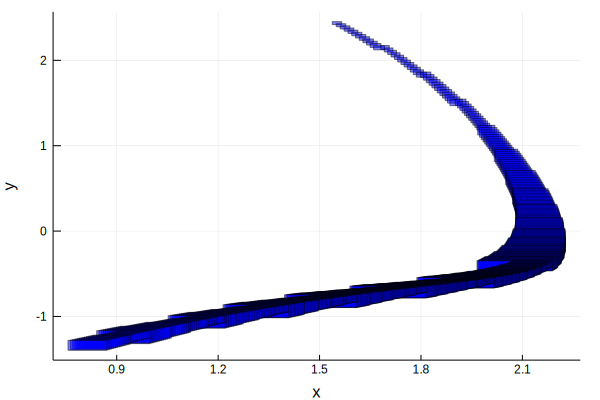

In [71]:
plot([Rsol.Xk[i].X for i in 1:1:nsets], xlab="x", ylab="y", alpha=.5)

### Appendix: auxiliary functions

In [2]:
function linearize(ùëÉ::IVP{<:BBCS}, Œ¥)

    # nonlinear ODE
    f = ùëÉ.s.f
    
    # initial set of current chunk
    ùëã‚ÇÄi = ùëÉ.x0

    # linearization point for current chunk
    c = center(ùëã‚ÇÄi)
    xÃÉ = c + Œ¥/2 * f(c)

    # evaluate Jacobian at the linearization point
    AxÃÉ = jacobian(f, xÃÉ) #  map(x -> evaluate(x, xÃÉ), Jf)
    bxÃÉ = f(xÃÉ) - AxÃÉ * xÃÉ

    # instantiate linearized system; it doesn't have state constraints
    ùëÜlin = ConstrainedAffineContinuousSystem(AxÃÉ, bxÃÉ, Universe(2));
    ùëÉlin = IVP(ùëÜlin, ùëã‚ÇÄi)
    return xÃÉ, ùëÉlin
end

linearize (generic function with 1 method)

In [3]:
function _add_chunk!(Rsets::Vector{ReachSet{Hyperrectangle{Float64}, Float64}}, Rlin, RÃÑerr, t0)
    #println("using hyperrect")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = Rlin.Xk[i].X ‚äï RÃÑerr
        Ri = overapproximate(Ri, Hyperrectangle)
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

function _add_chunk!(Rsets::Vector{ReachSet{Zonotope{Float64}, Float64}}, Rlin, RÃÑerr, t0)
    #println("using zonotopes")
    @inbounds for i in eachindex(Rlin.Xk)
        Ri = minkowski_sum(Rlin.Xk[i].X, convert(Zonotope, RÃÑerr))
        Ri = ReachSet(Ri, t0 + Rlin.Xk[i].t_start, t0 + Rlin.Xk[i].t_end)
        push!(Rsets, Ri)
    end
    return Rsets
end

_add_chunk! (generic function with 2 methods)

In [4]:
function admissible_error(AxÃÉ, Œ¥, Œ∏; n=2)
    @assert n == 2
    Œ¶‚ÇÅ_AŒ¥ = Œ¶‚ÇÅ(AxÃÉ, Œ¥)
    RÃÑerr = Hyperrectangle(zeros(2), Œ∏*Œ¥)
    lÃÑ = abs.(inv(Œ¶‚ÇÅ_AŒ¥)) * Œ∏ * Œ¥
    LÃÑ = Hyperrectangle(zeros(2), lÃÑ)
    return RÃÑerr, LÃÑ
end

admissible_error (generic function with 1 method)

In [5]:
function lagrange_remainder(f, Rlin, RÃÑerr, xÃÉ; n=2)
    @assert n == 2
    
    Hf‚ÇÅ = [‚àÇ(f[1], (2, 0)) ‚àÇ(f[1], (1, 1));
           ‚àÇ(f[1], (1, 1)) ‚àÇ(f[1], (0, 2))]
    Hf‚ÇÇ = [‚àÇ(f[2], (2, 0)) ‚àÇ(f[2], (1, 1));
           ‚àÇ(f[2], (1, 1)) ‚àÇ(f[2], (0, 2))]

    RÃÇlin = ConvexHullArray([Ri.X for Ri in Rlin.Xk]) ‚äï RÃÑerr
    RÃÇlin_rect = overapproximate(RÃÇlin, Hyperrectangle)

    Œæ = CH(Singleton(xÃÉ), RÃÇlin_rect)
    Œæ_rect = overapproximate(Œæ, Hyperrectangle)
    Œæ_box = convert(IntervalBox, Œæ_rect)

    Hf‚ÇÅ_box = map(Hf_ij -> evaluate(Hf_ij, Œæ_box), Hf‚ÇÅ)
    Hf‚ÇÇ_box = map(Hf_ij -> evaluate(Hf_ij, Œæ_box), Hf‚ÇÇ)

    RÃÇlin_zono = convert(Zonotope, RÃÇlin_rect)

    Œ≥ = abs.(RÃÇlin_zono.center - xÃÉ) + sum(abs.(RÃÇlin_zono.generators), dims=2)
    
    G = [sup.(abs.(Hf‚ÇÅ_box)), sup.(abs.(Hf‚ÇÇ_box))];
    li_zono = [(1/2 * transpose(Œ≥) * G[i] * Œ≥)[1, 1] for i in 1:n]
    L = Hyperrectangle(zeros(n), li_zono)
    return L
end

lagrange_remainder (generic function with 1 method)

### Other scripts

In [ ]:
#=
@time begin
# number of Taylor terms considered in the linearization
taylor_terms = 4

# define the working variables and fix the max order in the Taylor series expansion
x = set_variables("x", numvars=2, order=taylor_terms)

# define the ODE
f = Vector{TaylorN{Float64}}(undef, 2)
f[1] = x[2]
f[2] = x[2] * (1-x[1]^2) - x[1]

# define the initial-value problem
ùëã‚ÇÄ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
ùëÜ = BlackBoxContinuousSystem(f, 2)
ùëÉ = InitialValueProblem(ùëÜ, ùëã‚ÇÄ)

# take the gradient of the vector field symbolically
#‚àáf = [gradient(f[i]) for i in 1:2]

# take the Jacobian matrix of the vector field symbolically
#Jf = [‚àÇ(f[1], (1, 0)) ‚àÇ(f[1], (0, 1));
#      ‚àÇ(f[2], (1, 0)) ‚àÇ(f[2], (0, 1))]

# algorithm-specific options
ùëÇ = Options(:Œ¥ => 0.02, :Œ¥cont => 0.02/10, :max_order=>2, :Œ∏=>fill(0.05, 2))

# unwrap options
Œ¥ = O[:Œ¥]
Œ∏ = O[:Œ∏]

# collection of flowpipes; the set type depends on add_chunk! and the continuous post
Rsets = Vector{ReachSet{Hyperrectangle{Float64}, Float64}}()
end
=#

In [ ]:
#=
@time begin
xÃÉ, ùëÉlin = linearize(ùëÉ, Œ¥)
end;
ùëã‚ÇÄi = ùëÉlin.x0

# use zonotope-based continuous reach
@time begin
Rlin_zono = solve(ùëÉlin, Options(:T=>O[:Œ¥]), op=GLGM06(:Œ¥=>O[:Œ¥cont], :max_order=>O[:max_order]))
end;

# use decomposition-based continuous reach
@time begin
Rlin_box = solve(ùëÉlin, Options(:T=>O[:Œ¥]), op=BFFPSV18(:Œ¥=>O[:Œ¥cont]))
end;

plot(Rlin_zono, alpha=.5)
plot!(Rlin_box, alpha=.5, xlab="x", ylab="y")

Rlin = Rlin_zono  # decide which continuoust post to use

@time begin
RÃÑerr, LÃÑ = admissible_error(ùëÉlin.s.A, Œ¥, Œ∏; n=2)
L = lagrange_remainder(f, Rlin, RÃÑerr, xÃÉ; n=2)
end
=#